In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns

from scipy.stats import norm, skew, kurtosis, shapiro

In [24]:
def three_sigma(data):
    """三倍标准差法选取极值"""
    mean = data.daily_return.rolling(window=252, min_periods=242).mean()
    std = data.daily_return.rolling(window=252, min_periods=242).std()
    right = data[data.daily_return > mean + 2 * std].index
    left = data[data.daily_return < mean - 2 * std].index
    return left, right

def peak_detection(data, h=22, noise=0):
    """信号的尖峰干扰法判断极值"""
    n = len(data)
    peak_index = []
    for i in range(n-h):
        win = data[i:(i+h)]
        p_max, p_max_index = np.max(win), win.idxmax()[0]
        num = np.sum(win.values - p_max/6 - noise > 0)
        if num <= 3: 
            peak_index.append(p_max_index)
    return sorted(list(set(peak_index)))

def mean_peak_around(data, idx):
    """取出极值前后20天的数据取平均"""
    around = np.zeros([len(idx), 41])
    for i in range(len(idx)):
        m, n = data.index.get_loc(idx[i]) - 20, data.index.get_loc(idx[i]) + 20
        around[i, :] = data.values.flatten()[m:(n+1)]
    return np.mean(around, axis=0)

def plot_bar(positive, negative):
    """做出极值前后20天收益率的柱状图"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    
    ax1.bar(np.linspace(-20, 20, 41), mean_peak_around(df, positive))
    ax1.axvline(0, color='red', label='peak over threshold')
    ax1.set_xlabel('day')
    ax1.set_ylabel('mean return rate')
    
    ax2.bar(np.linspace(-20, 20, 41), mean_peak_around(df, negative))
    ax2.axvline(0, color='red', label='peak over threshold')
    ax2.set_xlabel('day')
    ax2.set_ylabel('mean return rate')
    plt.show()

def hist_around_peak(res):
    """做出极值前后20天收益率分布的直方图，与正态分布比较"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    def plot_hap(result, period, ax):
        mu, std = norm.fit(result)
        x = np.linspace(result.min(), result.max(), 50)
        y = norm.pdf(x, mu, std)

        sns.histplot(result, kde=True, label="fitted pdf", stat="density", ax=ax)
        ax.plot(x, y, label="norm pdf", color="red")
        ax.set_xlabel('day')
        ax.set_ylabel('frequency')
        ax.set_title(f"Distribution {period} Peak")
        ax.legend()

    plot_hap(res[:20], "Before", ax1)
    plot_hap(res[21:], "After", ax2)
    plt.show()

def eda(arr):
    l = [np.mean(arr), np.std(arr), skew(arr), kurtosis(arr)]
    statistics, p_value = shapiro(arr)
    l = l + [round(p_value, 3)]
    return np.array(l).reshape([1,5])

def peak_around(df):
    """输出极值前后20天收益率的各种统计结果用于分析"""
    rn, rp = three_sigma(df)
    res_n, res_p = mean_peak_around(df, rn), mean_peak_around(df, rp)
    
    plot_bar(rp, rn)
    plt.clf()
    hist_around_peak(res_p)
    hist_around_peak(res_n)
    
    tbl = pd.DataFrame(np.concatenate([eda(res_p[0:20]), eda(res_p[21:41]), 
                                       eda(res_n[0:20]), eda(res_n[21:41])], axis=0), 
                       columns=['mean', 'std', 'skew', 'kurtosis', 'p_value'], 
                       index=['p_before', 'p_after', 'n_before', 'n_after'])
    print(tbl)

In [25]:
conn = pymysql.connect(
    host="192.168.7.93",
    user="quantchina",
    password="zMxq7VNYJljTFIQ8",
    database="wind",
    charset="gbk"
)

cursor = conn.cursor()
code = ['000016.SH', '000300.SH', '000852.SH', '000905.SH', '000985.CSI', '399006.SZ', '399303.SZ']
df_dict = {}

for i in range(len(code)):
    query = "SELECT TRADE_DT, S_DQ_PCTCHANGE FROM AINDEXEODPRICES WHERE S_INFO_WINDCODE='{ticker}' and TRADE_DT>='20100101' ORDER BY TRADE_DT".format(ticker=code[i])
    cursor.execute(query)

    data = cursor.fetchall()
    df = pd.DataFrame(data, columns=['date','daily_return'])
    df.set_index('date', inplace=True)
    df['daily_return'] = df['daily_return'].astype(float) / 100
    df_dict[code[i]] = df

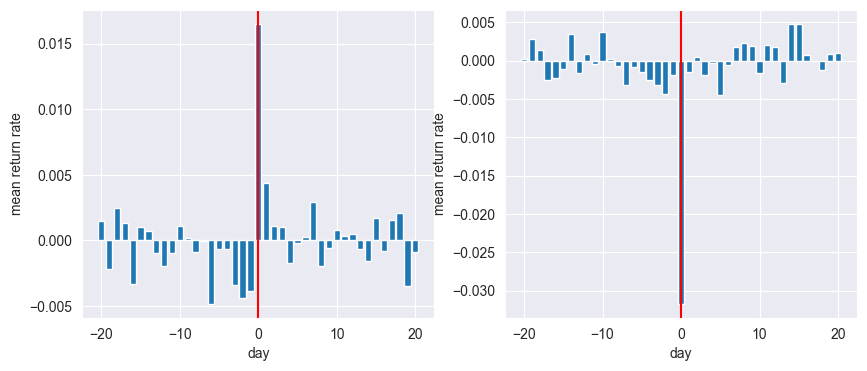

<Figure size 640x480 with 0 Axes>

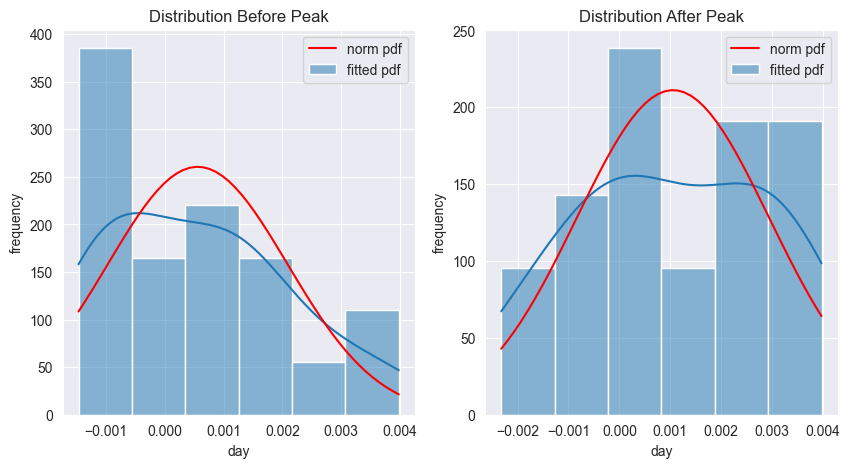

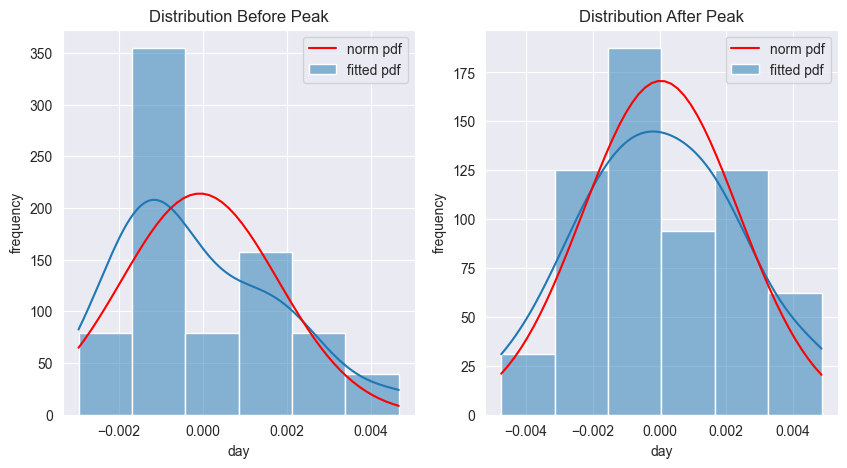

              mean       std      skew  kurtosis  p_value
p_before  0.000557  0.001531  0.535968 -0.616340    0.243
p_after   0.001052  0.001889 -0.100748 -1.134782    0.498
n_before -0.000069  0.001864  0.781301 -0.048355    0.117
n_after   0.000039  0.002337  0.101115 -0.379131    0.983


In [26]:
df1 = df_dict['000016.SH'].loc[:'20221231']
peak_around(df1)

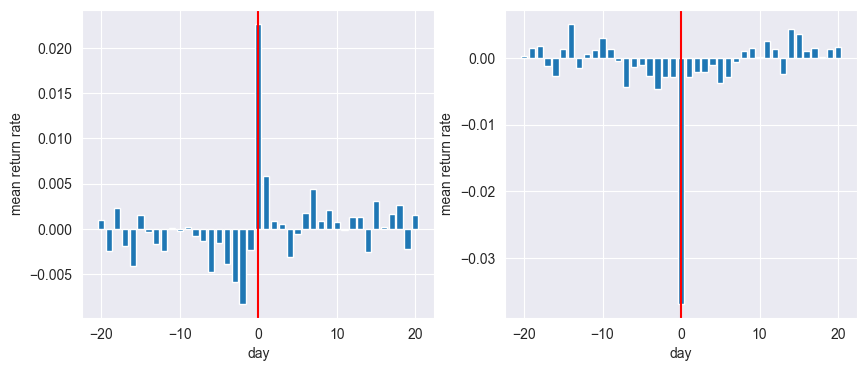

<Figure size 640x480 with 0 Axes>

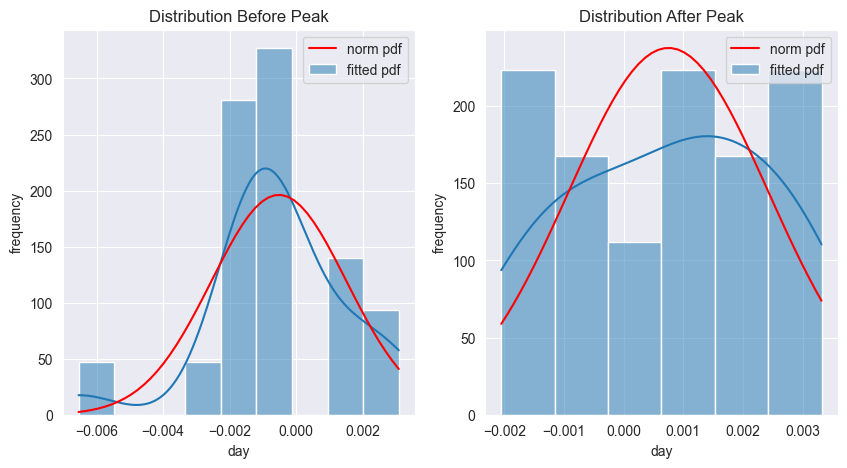

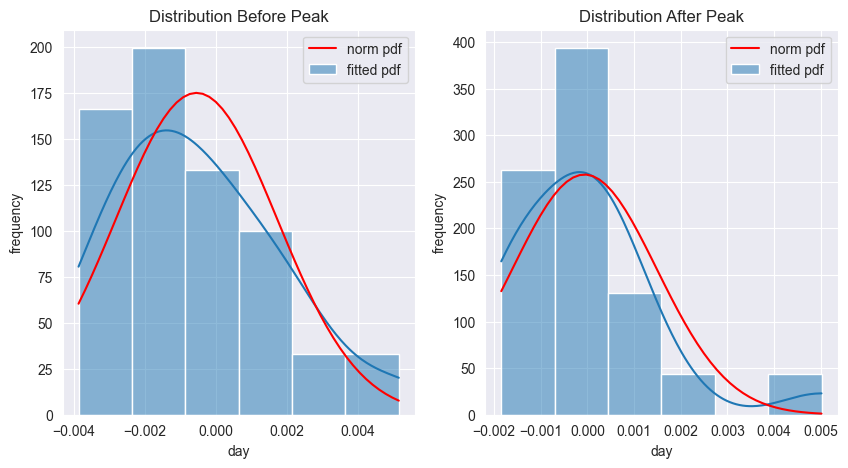

              mean       std      skew  kurtosis  p_value
p_before -0.000520  0.002034 -0.682974  1.962011    0.029
p_after   0.000751  0.001678 -0.121162 -1.169084    0.382
n_before -0.000538  0.002277  0.640075 -0.045471    0.511
n_after  -0.000059  0.001548  1.556691  3.256201    0.006


In [27]:
df2 = df_dict['000300.SH'].loc[:'20221231']
peak_around(df2)

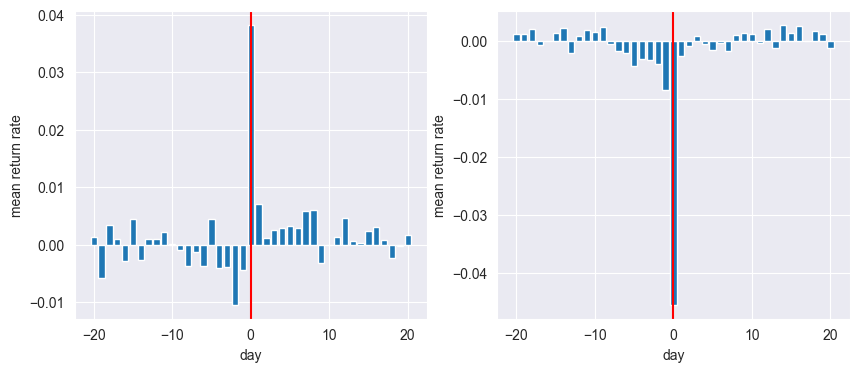

<Figure size 640x480 with 0 Axes>

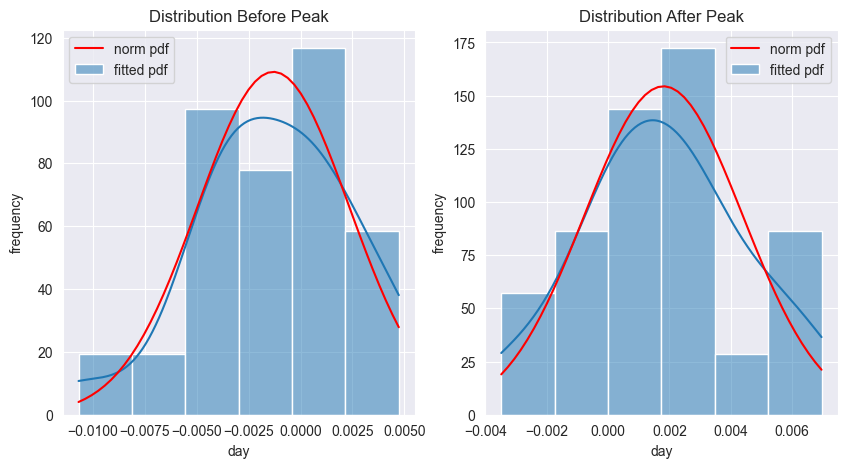

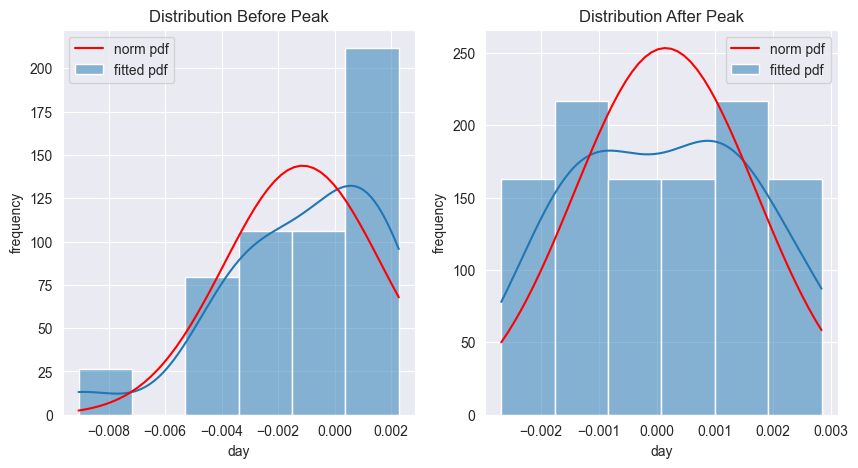

              mean       std      skew  kurtosis  p_value
p_before -0.001311  0.003656 -0.454414  0.241369    0.569
p_after   0.001807  0.002584  0.052110 -0.380376    0.976
n_before -0.001128  0.002775 -1.052438  0.930800    0.049
n_after   0.000146  0.001574  0.042783 -1.056115    0.528


In [28]:
df3 = df_dict['000852.SH'].loc[:'20221231']
peak_around(df3)

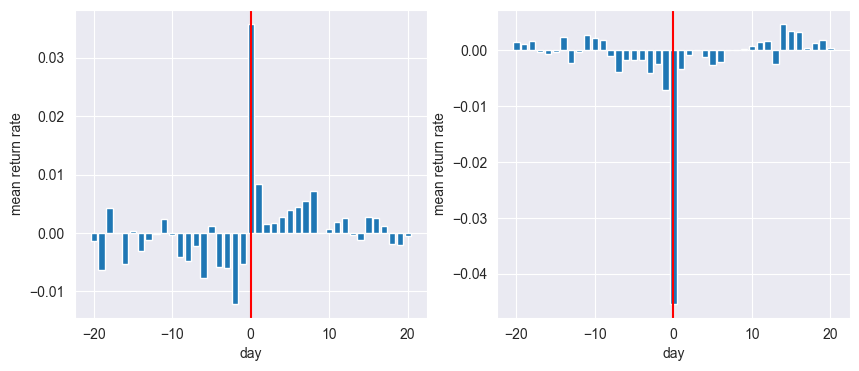

<Figure size 640x480 with 0 Axes>

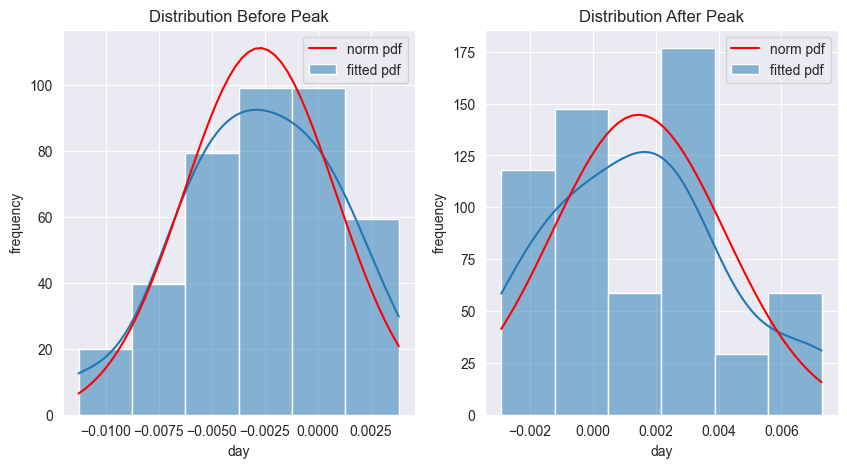

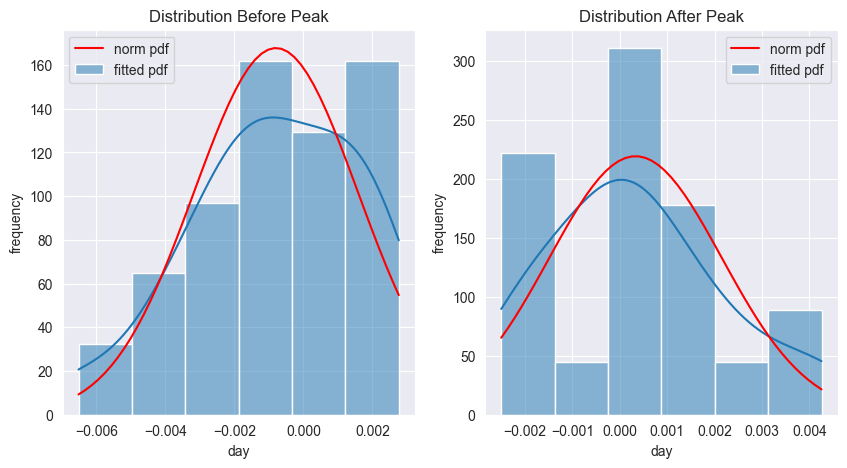

              mean       std      skew  kurtosis  p_value
p_before -0.002731  0.003585 -0.312115 -0.190040    0.945
p_after   0.001457  0.002758  0.440762 -0.395363    0.371
n_before -0.000794  0.002378 -0.505781 -0.329994    0.461
n_after   0.000335  0.001820  0.513848 -0.361265    0.436


In [29]:
df4 = df_dict['000905.SH'].loc[:'20221231']
peak_around(df4)

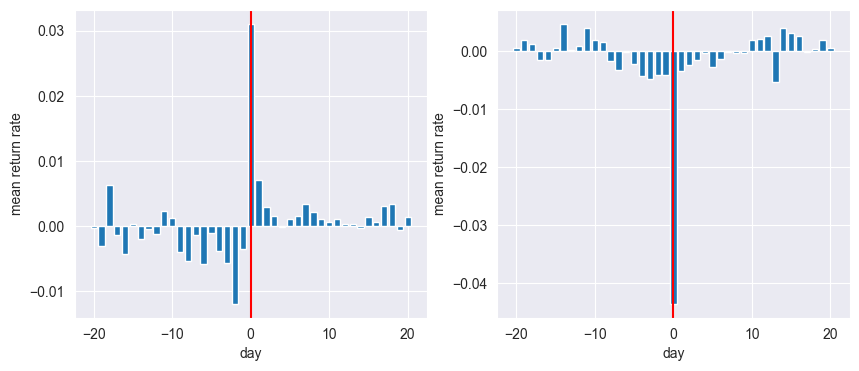

<Figure size 640x480 with 0 Axes>

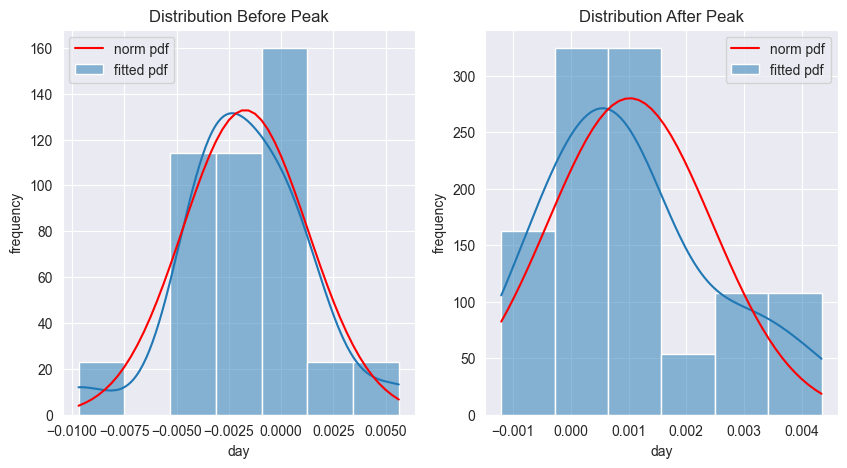

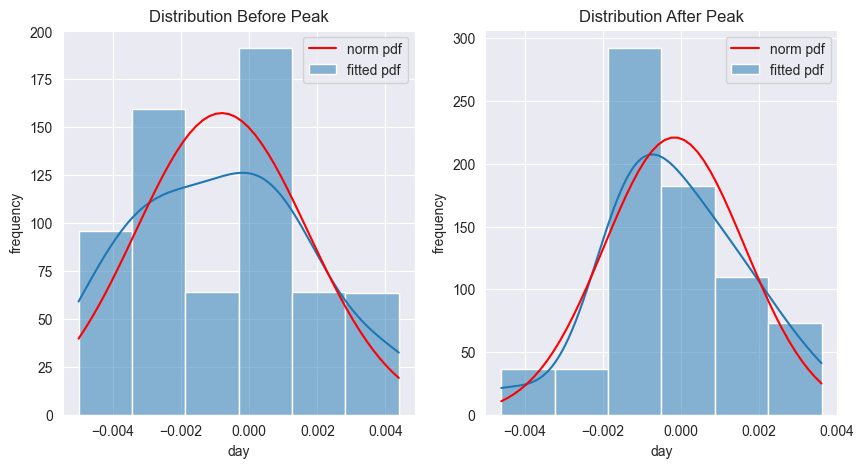

              mean       std      skew  kurtosis  p_value
p_before -0.001720  0.003003 -0.131612  1.511929    0.234
p_after   0.001023  0.001424  0.702646 -0.217830    0.316
n_before -0.000807  0.002534  0.235329 -0.695531    0.777
n_after  -0.000169  0.001805 -0.108542  0.309073    0.779


In [30]:
df5 = df_dict['000985.CSI'].loc[:'20221231']
peak_around(df5)

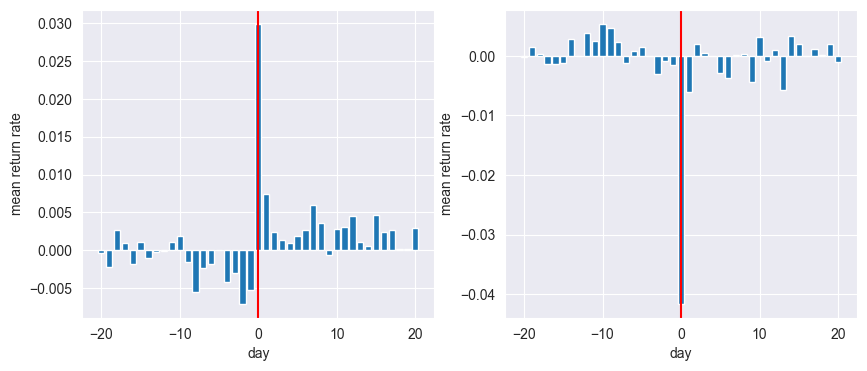

<Figure size 640x480 with 0 Axes>

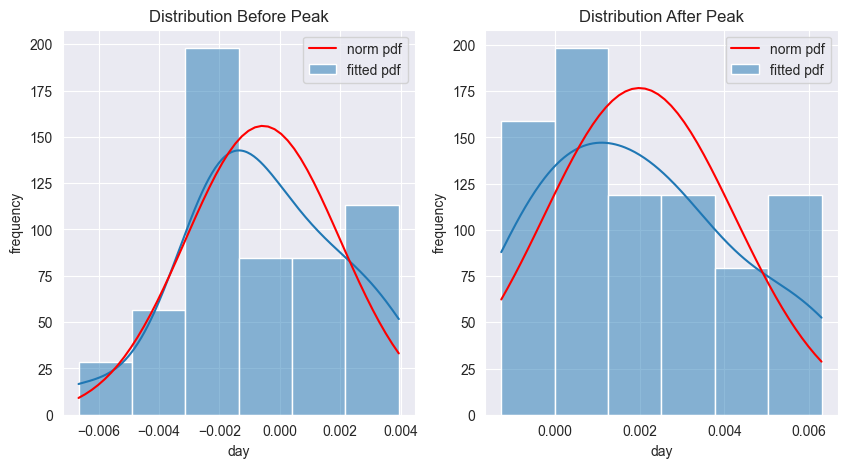

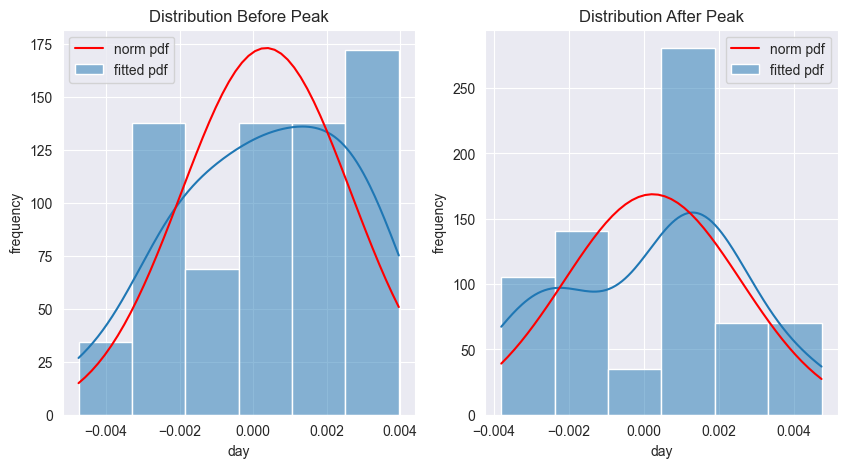

              mean       std      skew  kurtosis  p_value
p_before -0.000564  0.002559 -0.165189 -0.123871    0.716
p_after   0.001992  0.002257  0.380879 -0.878256    0.322
n_before  0.000355  0.002303 -0.344656 -0.736335    0.632
n_after   0.000236  0.002364 -0.123297 -0.923077    0.246


In [31]:
df6 = df_dict['399006.SZ'].loc[:'20221231']
peak_around(df6)

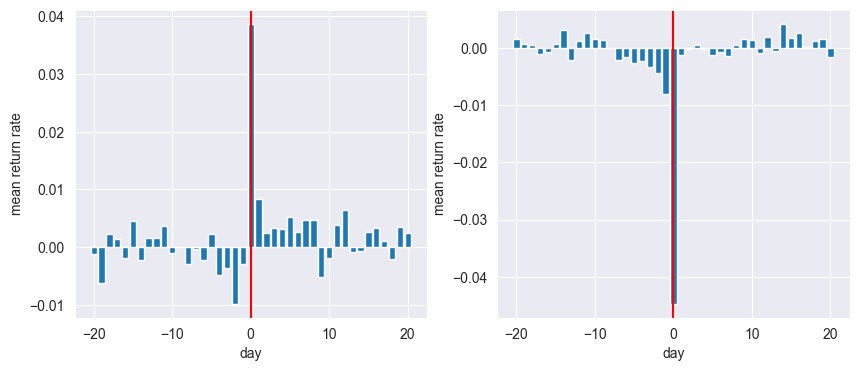

<Figure size 640x480 with 0 Axes>

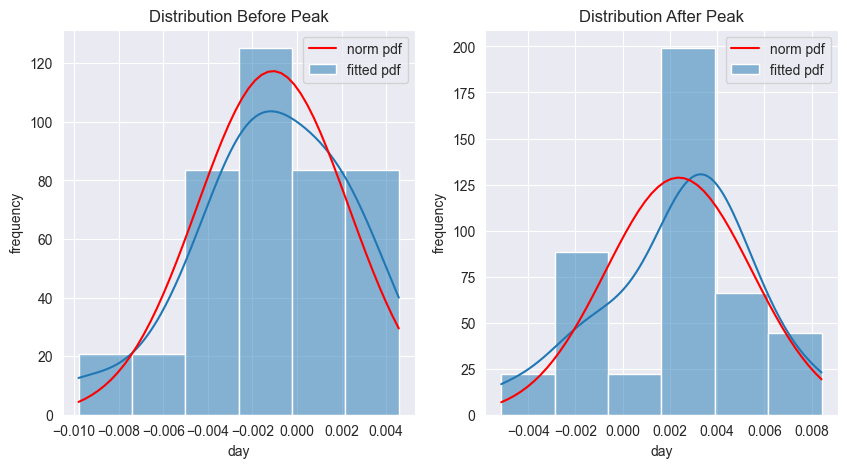

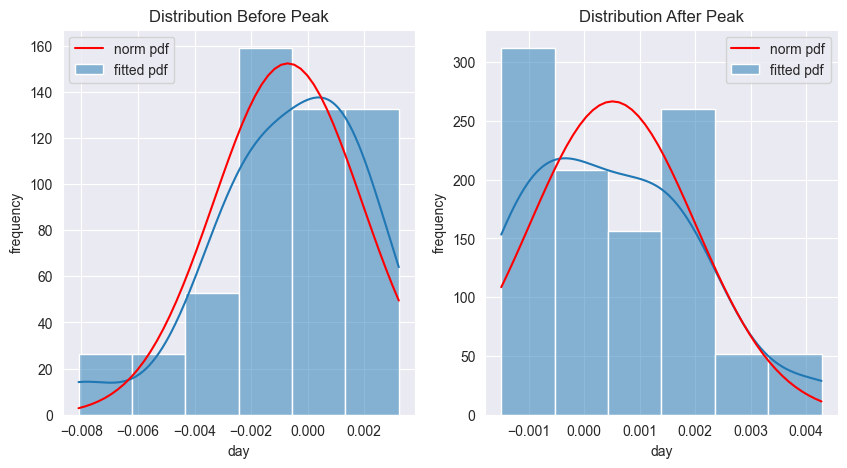

              mean       std      skew  kurtosis  p_value
p_before -0.001084  0.003399 -0.587328  0.234636    0.687
p_after   0.002374  0.003098 -0.514466  0.143891    0.474
n_before -0.000706  0.002620 -0.940051  0.947194    0.198
n_after   0.000515  0.001497  0.614333 -0.141375    0.291


In [32]:
df7 = df_dict['399303.SZ'].loc[:'20221231']
peak_around(df7)

In [33]:
def peak_around2(df):
    rn, rp = peak_detection(-df.loc['20110101':'20221231']), peak_detection(df.loc['20110101':'20221231'])
    res_n, res_p = mean_peak_around(df, rn), mean_peak_around(df, rp)
    
    plot_bar(rp, rn)
    plt.clf()
    hist_around_peak(res_p)
    hist_around_peak(res_n)
    
    tbl = pd.DataFrame(np.concatenate([eda(res_p[0:20]), eda(res_p[21:41]), 
                                       eda(res_n[0:20]), eda(res_n[21:41])], axis=0), 
                       columns=['mean', 'std', 'skew', 'kurtosis', 'p_value'], 
                       index=['p_before', 'p_after', 'n_before', 'n_after'])
    print(tbl)

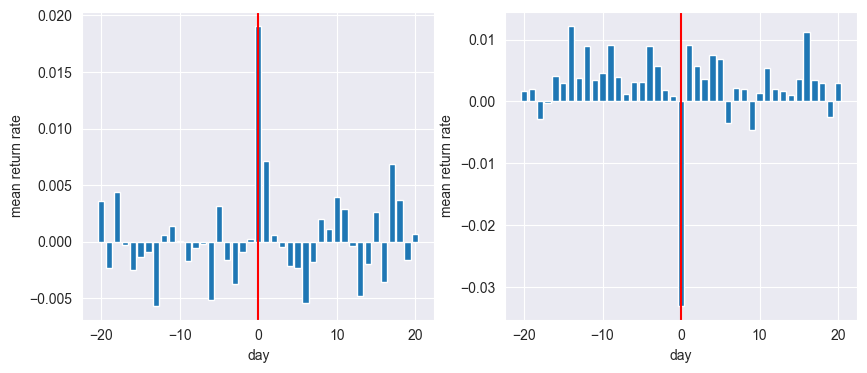

<Figure size 640x480 with 0 Axes>

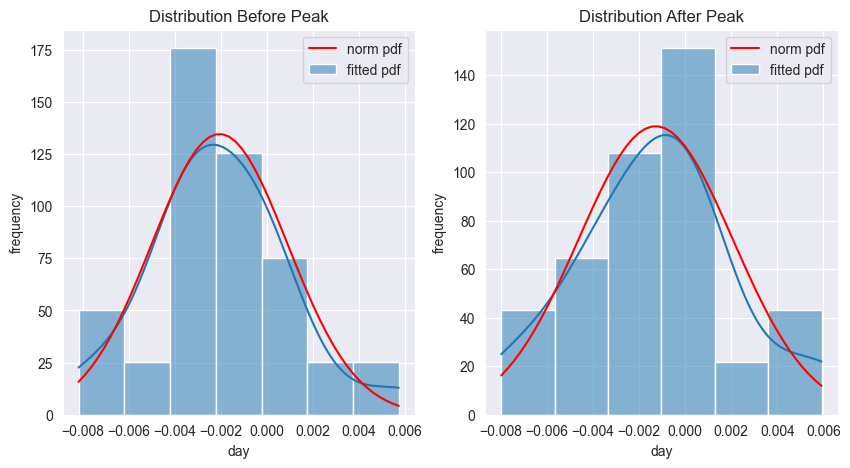

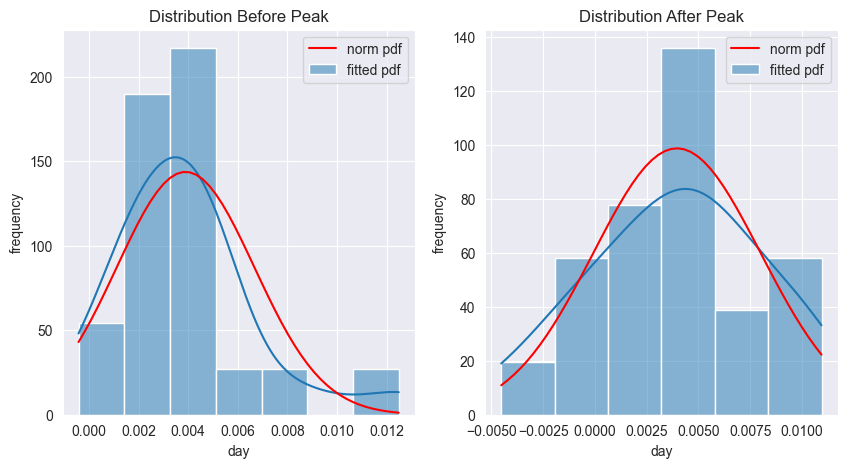

              mean       std      skew  kurtosis  p_value
p_before -0.002055  0.002964  0.404079  0.846562    0.551
p_after  -0.001277  0.003354  0.170990  0.070462    0.489
n_before  0.003897  0.002777  1.386701  2.465005    0.022
n_after   0.003965  0.004045 -0.175497 -0.652405    0.905


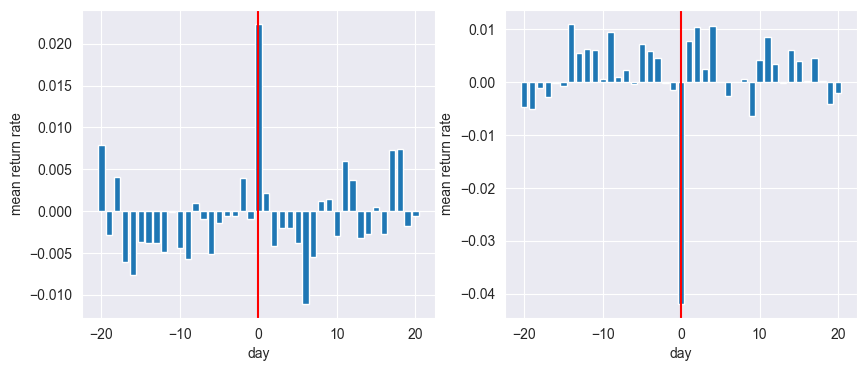

<Figure size 640x480 with 0 Axes>

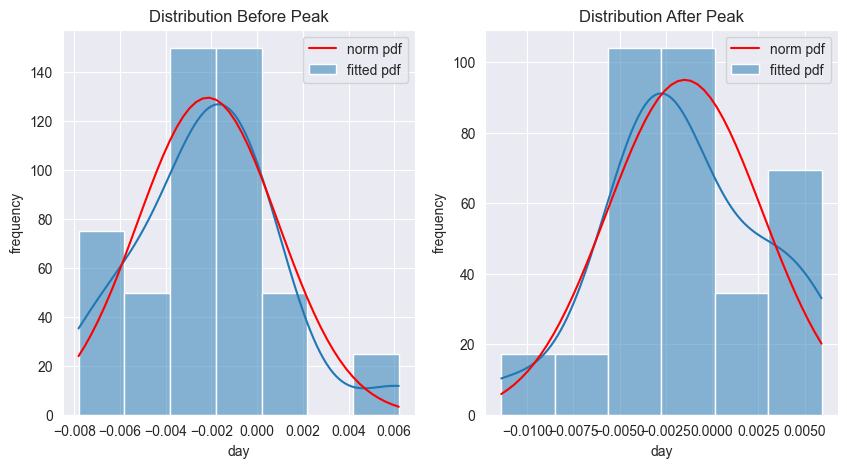

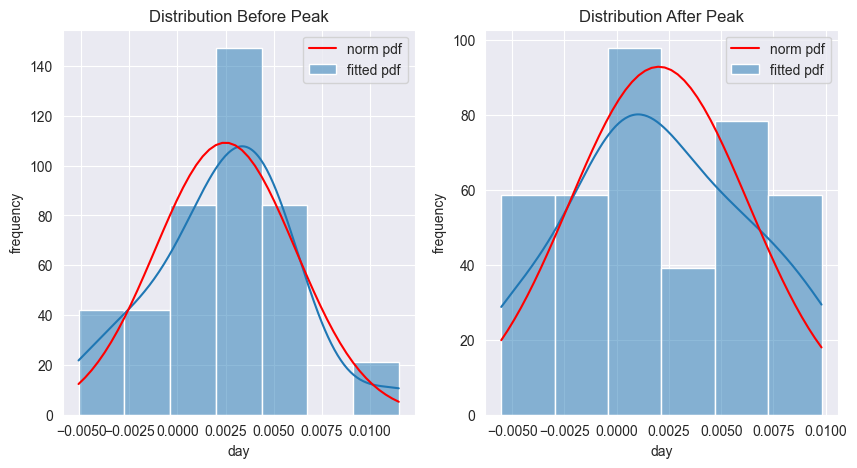

              mean       std      skew  kurtosis  p_value
p_before -0.002154  0.003078  0.475363  0.867738    0.509
p_after  -0.001482  0.004201 -0.107548 -0.152525    0.583
n_before  0.002489  0.003653  0.072677  0.437611    0.657
n_after   0.002014  0.004293  0.072766 -0.787095    0.572


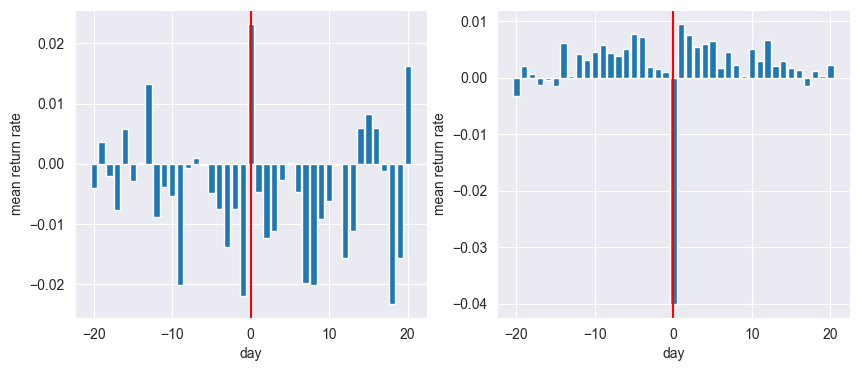

<Figure size 640x480 with 0 Axes>

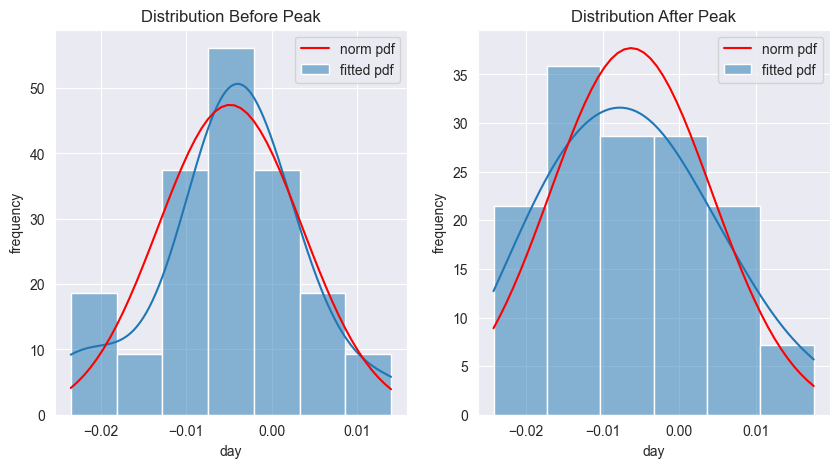

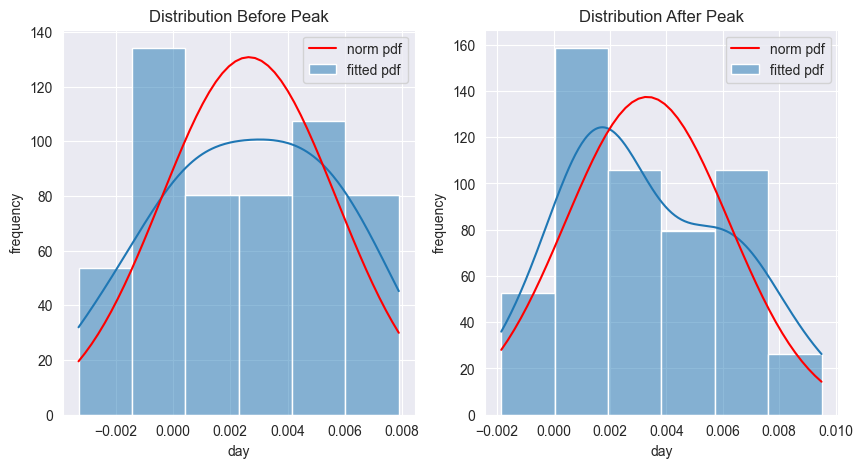

              mean       std      skew  kurtosis  p_value
p_before -0.004872  0.008410 -0.309253  0.589879    0.334
p_after  -0.006267  0.010577  0.333297 -0.475574    0.937
n_before  0.002648  0.003051 -0.123036 -0.895418    0.849
n_after   0.003322  0.002903  0.347470 -0.760656    0.424


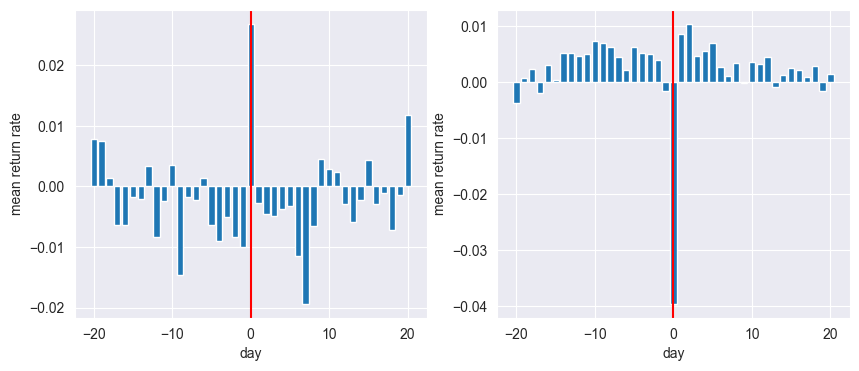

<Figure size 640x480 with 0 Axes>

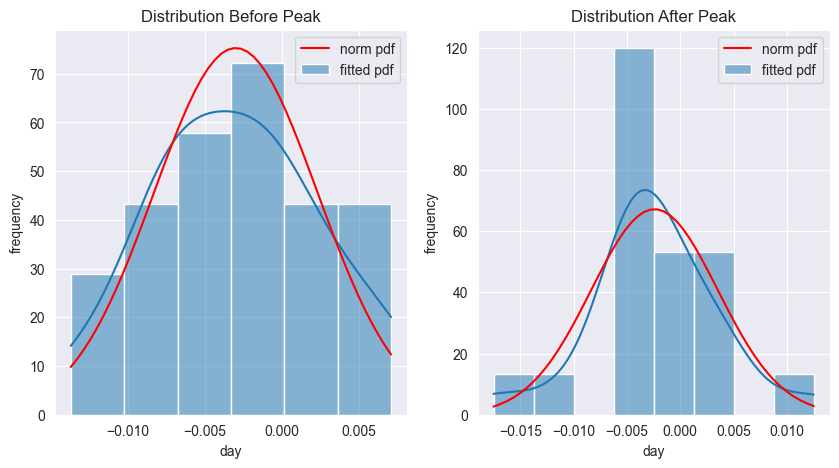

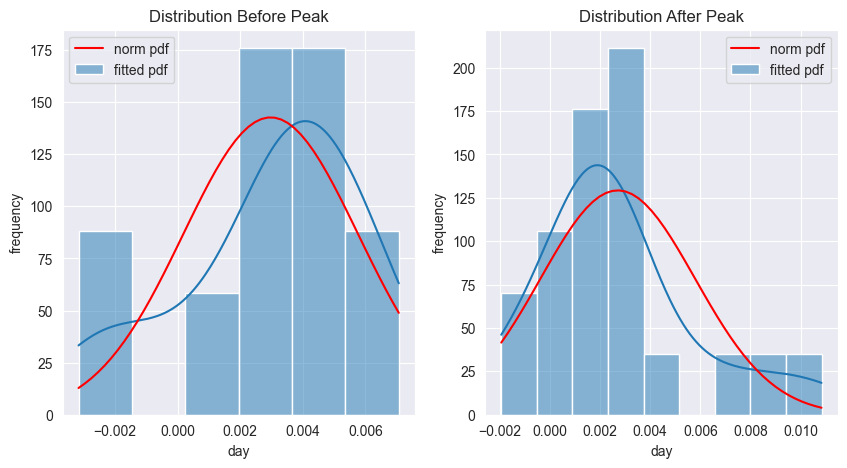

              mean       std      skew  kurtosis  p_value
p_before -0.003001  0.005299  0.083968 -0.570504    0.921
p_after  -0.002418  0.005938 -0.004773  1.497337    0.139
n_before  0.002972  0.002796 -0.748423 -0.331072    0.123
n_after   0.002710  0.003085  1.070177  0.885291    0.035


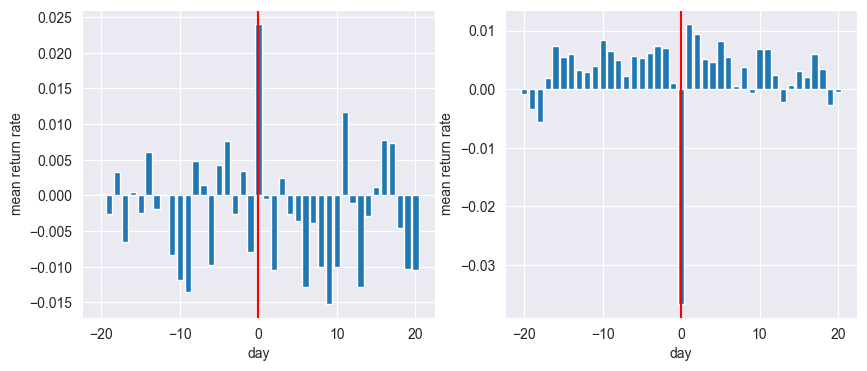

<Figure size 640x480 with 0 Axes>

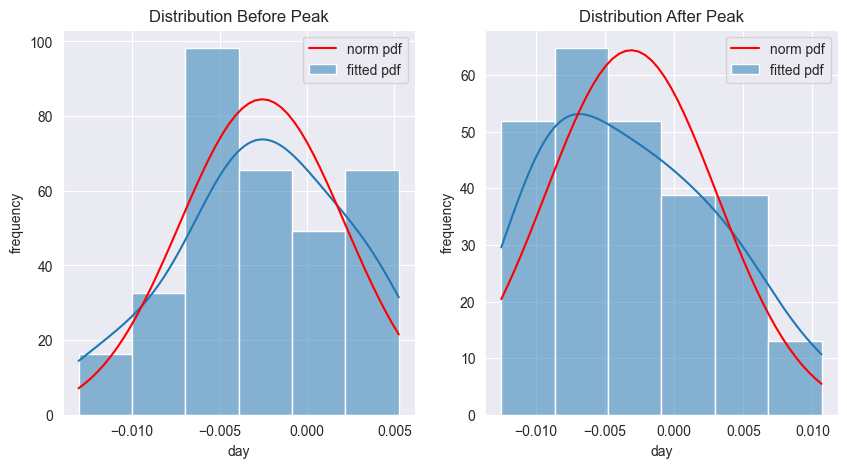

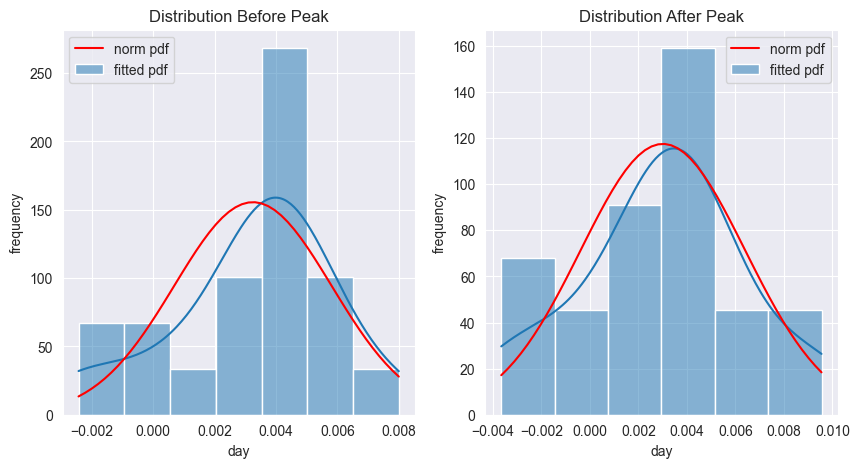

              mean       std      skew  kurtosis  p_value
p_before -0.002553  0.004720 -0.345512 -0.441797    0.710
p_after  -0.003107  0.006193  0.439735 -0.724128    0.453
n_before  0.003249  0.002564 -0.640985  0.099131    0.278
n_after   0.003012  0.003394 -0.134559 -0.207177    0.676


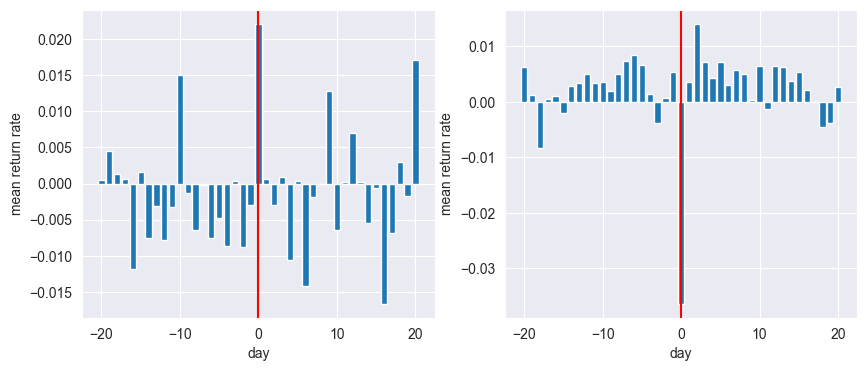

<Figure size 640x480 with 0 Axes>

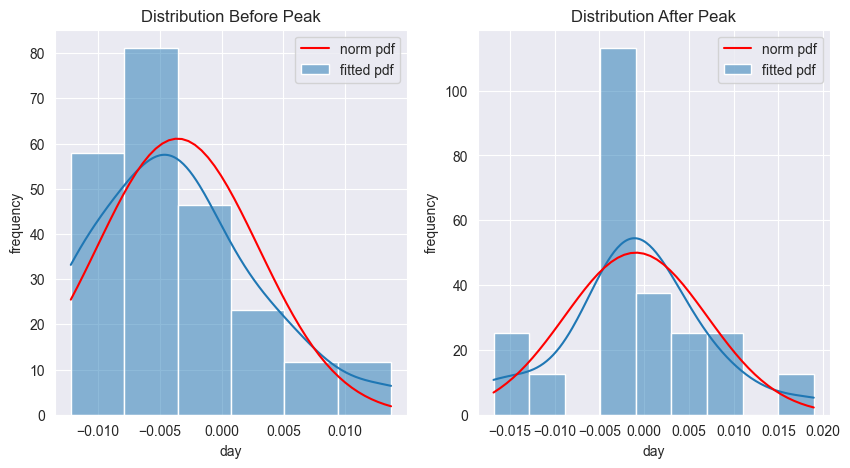

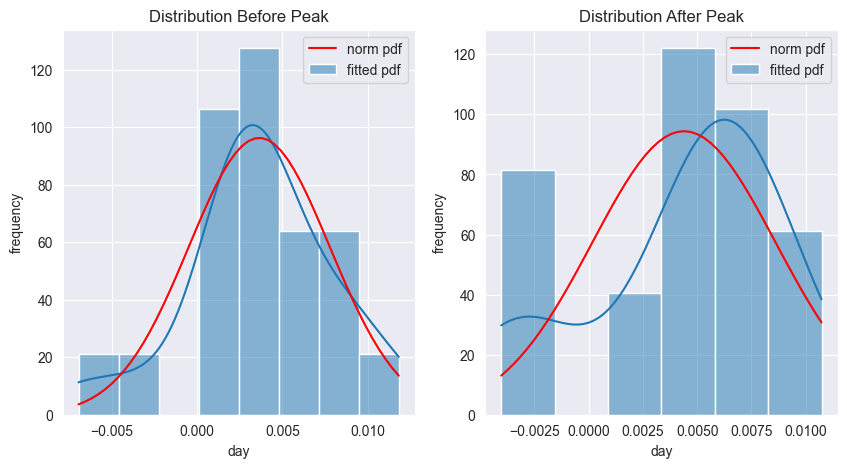

              mean       std      skew  kurtosis  p_value
p_before -0.003550  0.006531  0.801382  0.374547    0.134
p_after  -0.000922  0.007978  0.142903  0.792842    0.210
n_before  0.003641  0.004141 -0.437746  0.727485    0.336
n_after   0.004392  0.004226 -0.797424 -0.464962    0.024


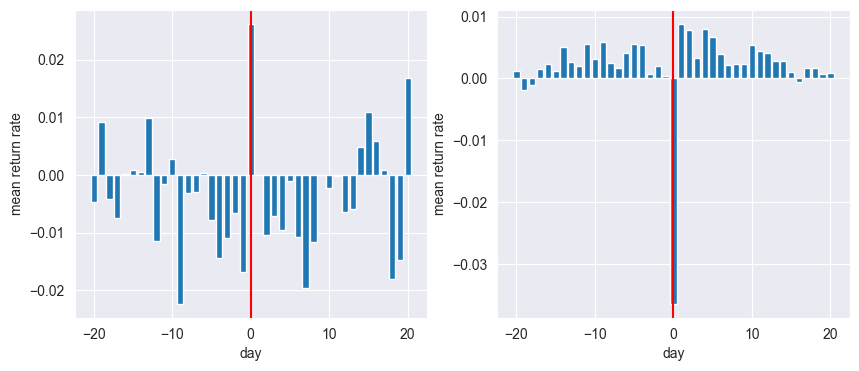

<Figure size 640x480 with 0 Axes>

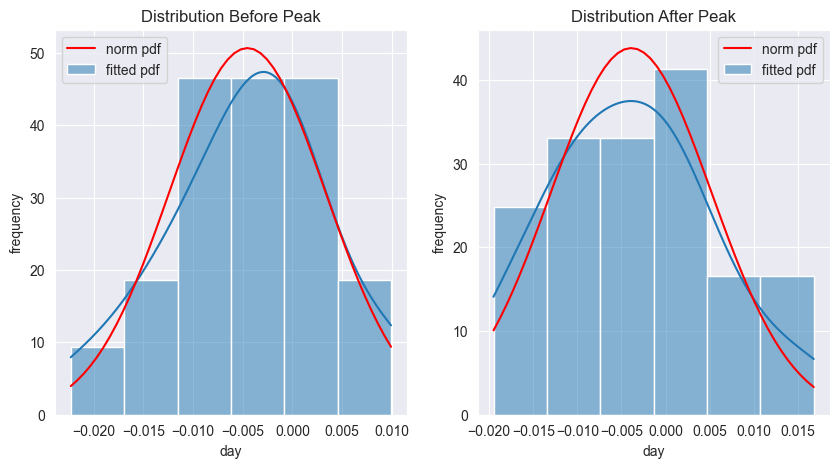

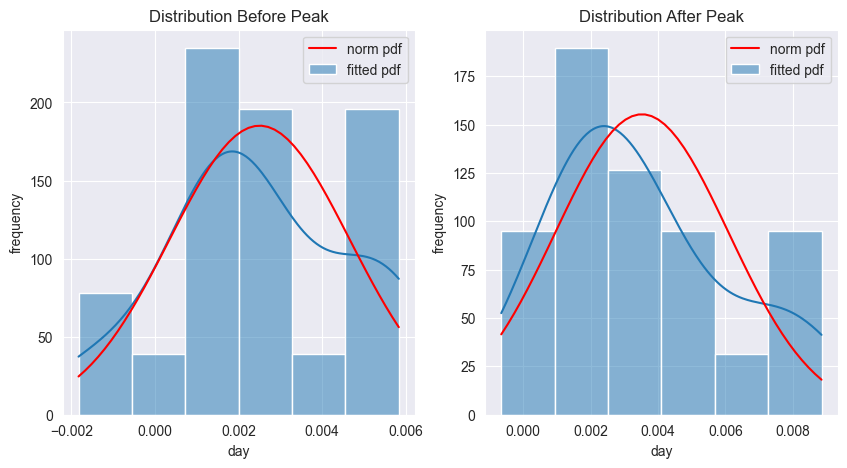

              mean       std      skew  kurtosis  p_value
p_before -0.004524  0.007872 -0.269332 -0.137977    0.887
p_after  -0.003897  0.009104  0.323429 -0.313817    0.906
n_before  0.002505  0.002155 -0.041246 -0.741640    0.305
n_after   0.003525  0.002568  0.607544 -0.574976    0.223


In [34]:
for value in df_dict.values():
    peak_around2(value)

In [35]:
# 找出2023年极值，3sigma法
sigma_p = {}
sigma_n = {}
for key, value in df_dict.items():
    rn, rp = three_sigma(value)
    sigma_p[key] = value.loc[rp,:].loc['20230101':'20231231']
    sigma_n[key] = value.loc[rn,:].loc['20230101':'20231231']

In [36]:
# 信号的峰值判断法
peak_p = {}
peak_n = {}
for key, value in df_dict.items():
    rn, rp = peak_detection(-value), peak_detection(value)
    peak_p[key] = value.loc[rp,:].loc['20230101':'20231231']
    peak_n[key] = value.loc[rn,:].loc['20230101':'20231231']

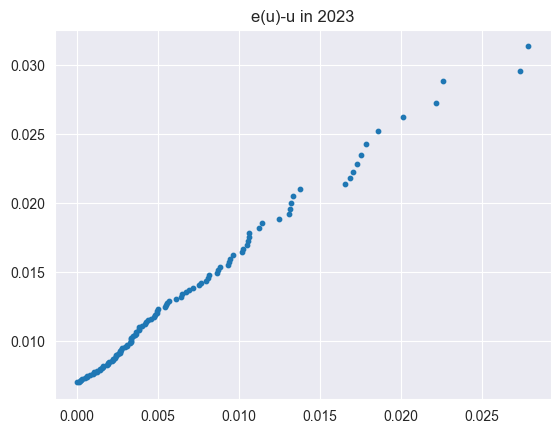

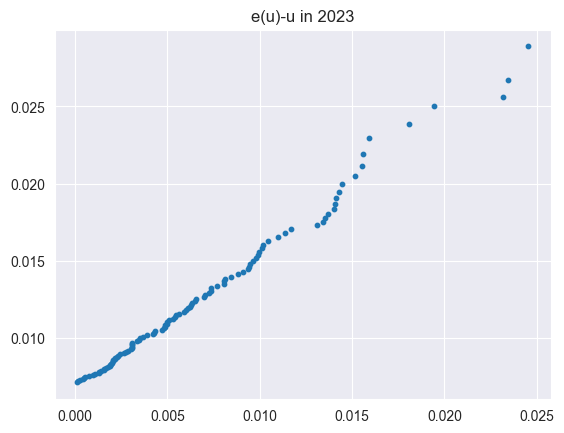

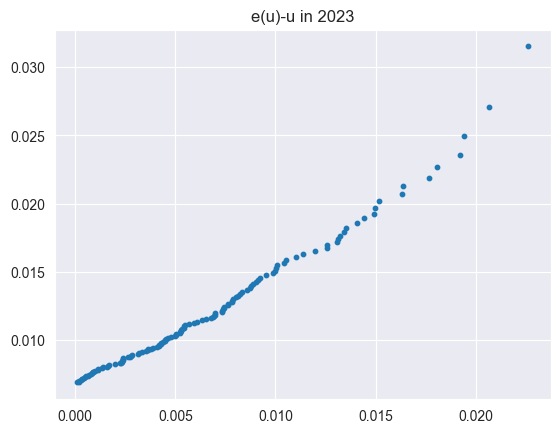

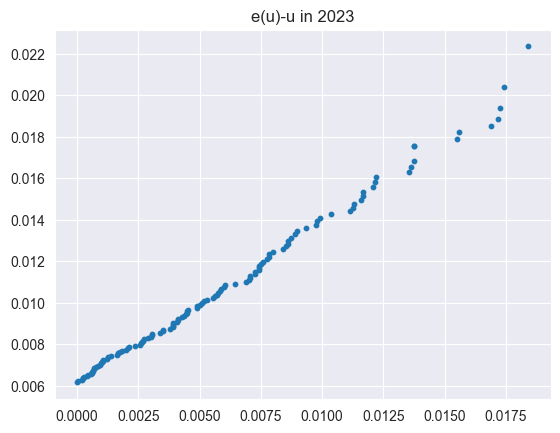

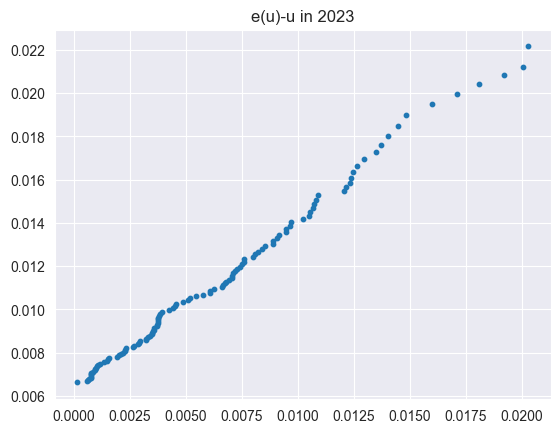

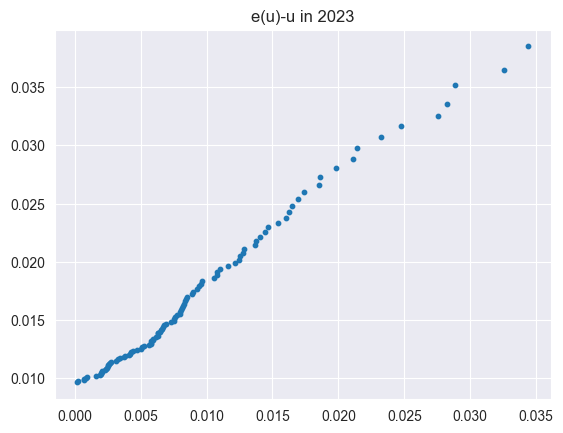

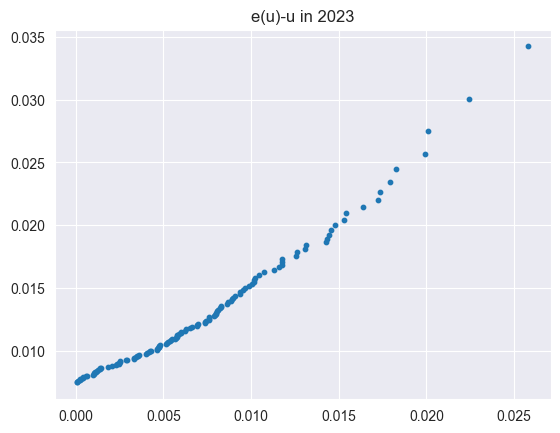

In [37]:
# POT阈值判断法
def threshold(returns, start_date, end_date):
    r = returns.loc[start_date:end_date]
    u_range = np.array(sorted(r[r.values > 0].values))
    e_n = np.zeros(u_range.size)
    for k in range(len(u_range)):
        excess = r[r > u_range[k]]
        e_n[k] = np.mean(excess)
    plt.scatter(u_range, e_n, s=10)
    plt.title(f"e(u)-u in {start_date[0:4]}")  
    
for key, df in df_dict.items():
    threshold(df, '20230101', '20231231')
    plt.show()

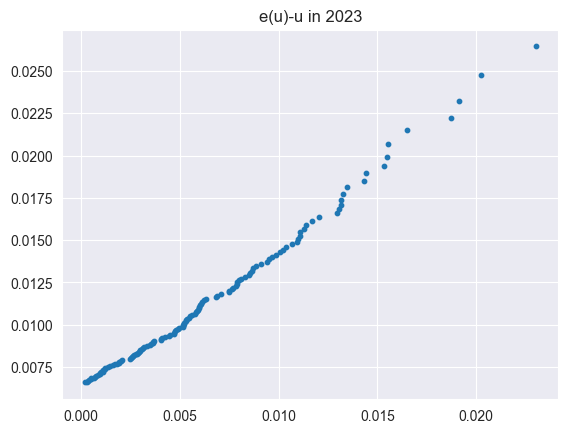

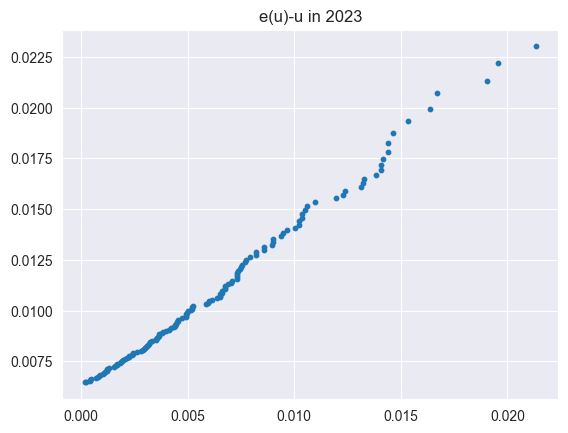

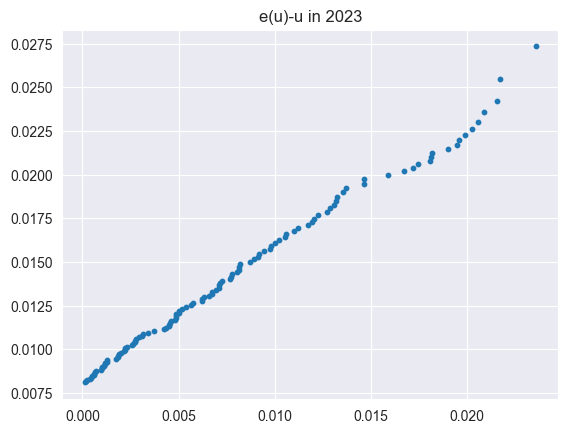

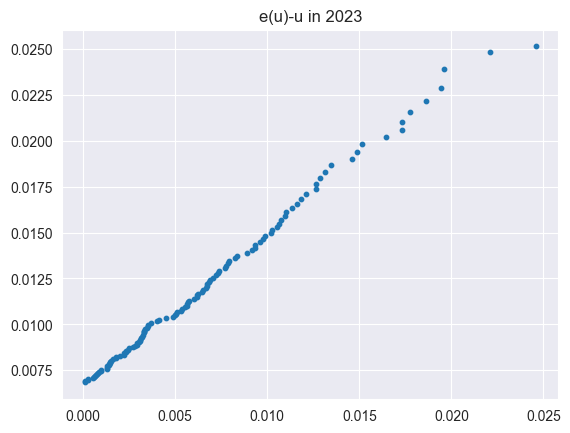

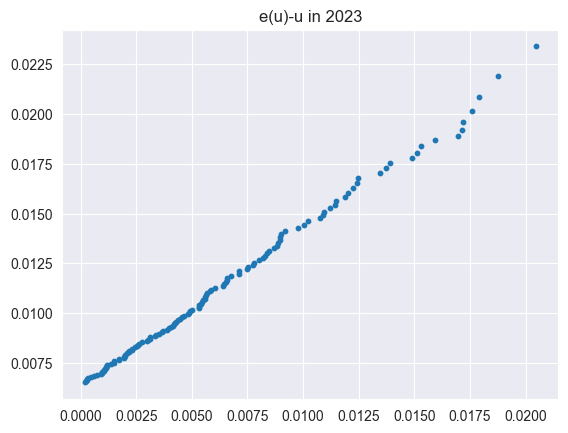

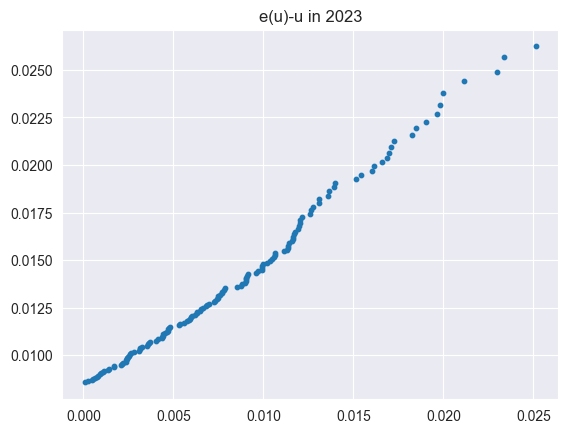

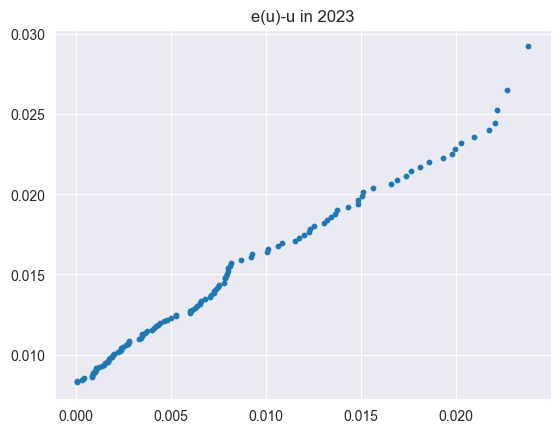

In [38]:
for key, df in df_dict.items():
    threshold(-df, '20230101', '20231231')
    plt.show()

In [39]:
def hill(returns, start_date, end_date, ax):
    r = returns.loc[start_date:end_date]
    u_range = np.array(sorted(r[r.values > 0].values))
    g = np.zeros(u_range.size)
    for k in range(len(u_range)):
        log_ratio = np.log(u_range[:(k+1)] / u_range[k])
        g[k] = np.mean(log_ratio)
    ax.plot(np.arange(1, len(u_range)+1), g)
    ax.set_title(f"e(u)-u in {start_date[0:4]}")

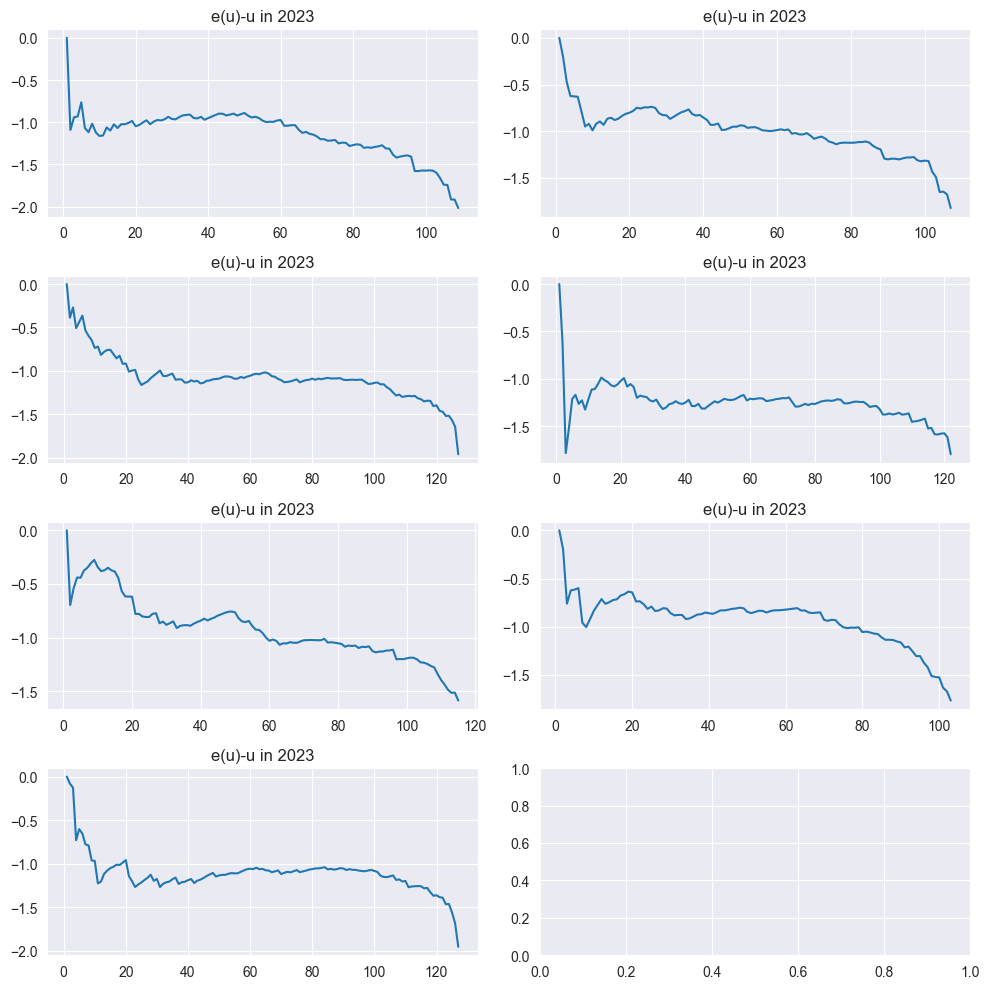

In [40]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i, (key, df) in enumerate(df_dict.items()):
    hill(df, '20230101', '20231231', axes[i // 2, i % 2])

plt.tight_layout()
plt.show()

In [41]:
u_positive = [0.018, 0.016, 0.015, 0.0137, 0.0146, 0.022, 0.0175]
u_negative = [0.0155, 0.014, 0.018, 0.017, 0.0165, 0.018, 0.022]
 
pot_p = {}
pot_n = {}
i = 0
for key, df in df_dict.items():
    data_y = df.loc['20230101': '20231231']
    pot_p[key] = data_y[data_y.values > u_positive[i]]
    pot_n[key] = data_y[data_y.values < -u_negative[i]]
    i = i + 1

In [42]:
combined_df_p = pd.DataFrame()
for key, df in sigma_p.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = '3sigma'
    combined_df_p = pd.concat([combined_df_p, df_output])

for key, df in peak_p.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = 'method6'
    combined_df_p = pd.concat([combined_df_p, df_output])

for key, df in pot_p.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = 'POT'
    combined_df_p = pd.concat([combined_df_p, df_output])
print(combined_df_p)

        date  daily_return     ticker  method
0   20230220      0.027302  000016.SH  3sigma
1   20230725      0.031341  000016.SH  3sigma
2   20230728      0.027828  000016.SH  3sigma
3   20230922      0.022135  000016.SH  3sigma
4   20231228      0.022571  000016.SH  3sigma
..       ...           ...        ...     ...
2   20230829      0.034242  399303.SZ     POT
3   20230922      0.020082  399303.SZ     POT
4   20231024      0.019904  399303.SZ     POT
5   20231106      0.022438  399303.SZ     POT
6   20231228      0.017907  399303.SZ     POT

[90 rows x 4 columns]


In [43]:
combined_df_n = pd.DataFrame()
for key, df in sigma_n.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = '3sigma'
    combined_df_n = pd.concat([combined_df_n, df_output])

for key, df in peak_n.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = 'method6'
    combined_df_n = pd.concat([combined_df_n, df_output])

for key, df in pot_n.items():
    df_output = df.reset_index()
    df_output['ticker'] = key
    df_output['method'] = 'POT'
    combined_df_n = pd.concat([combined_df_n, df_output])
print(combined_df_n)

        date  daily_return     ticker  method
0   20230811     -0.023026  000016.SH  3sigma
1   20231019     -0.026452  000016.SH  3sigma
2   20231205     -0.020266  000016.SH  3sigma
3   20231213     -0.019140  000016.SH  3sigma
0   20230811     -0.023005  000300.SH  3sigma
..       ...           ...        ...     ...
0   20230216     -0.022706  399303.SZ     POT
1   20230421     -0.029236  399303.SZ     POT
2   20230606     -0.022155  399303.SZ     POT
3   20230626     -0.022054  399303.SZ     POT
4   20231023     -0.023803  399303.SZ     POT

[98 rows x 4 columns]


In [44]:
# combined_df_n.to_excel('negative.xlsx', index=False)
# combined_df_p.to_excel('positive.xlsx', index=False)